In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Load CSV file and examine its content

In [2]:
file_path = 'C:/Users/natha/OneDrive/Bureau/Interview trainings/Coding/Aquatic/Weather_Forecast_Ideas/data/chicago_beach_weather.csv'
weather_data = pd.read_csv(file_path)

weather_data.head()

,Station Name,Measurement Timestamp,Air Temperature
0,63rd Street Weather Station,01/01/2016 12:00:00 AM,-2.80
1,Oak Street Weather Station,01/01/2016 12:00:00 AM,-2.30
2,Foster Weather Station,01/01/2016 12:00:00 AM,-3.67
3,63rd Street Weather Station,01/01/2016 01:00:00 AM,-3.40
4,Foster Weather Station,01/01/2016 01:00:00 AM,-4.56


In [3]:
weather_data['Measurement Timestamp'] = pd.to_datetime(weather_data['Measurement Timestamp'])
weather_data.set_index('Measurement Timestamp', inplace=True)

weather_data.head()

,Station Name,Air Temperature
Measurement Timestamp,,
2016-01-01 00:00:00,63rd Street Weather Station,-2.80
2016-01-01 00:00:00,Oak Street Weather Station,-2.30
2016-01-01 00:00:00,Foster Weather Station,-3.67
2016-01-01 01:00:00,63rd Street Weather Station,-3.40
2016-01-01 01:00:00,Foster Weather Station,-4.56


In [4]:
df_pivot = weather_data.pivot(columns='Station Name', values='Air Temperature')

df_pivot.head()

Station Name,63rd Street Weather Station,Foster Weather Station,Oak Street Weather Station
Measurement Timestamp,,,
2016-01-01 00:00:00,-2.8,-3.67,-2.3
2016-01-01 01:00:00,-3.4,-4.56,-3.2
2016-01-01 02:00:00,-4.2,-5.50,-4.0
2016-01-01 03:00:00,-5.1,-6.28,-4.8
2016-01-01 04:00:00,-5.7,-7.00,-5.5


Let's plot the 3 time series

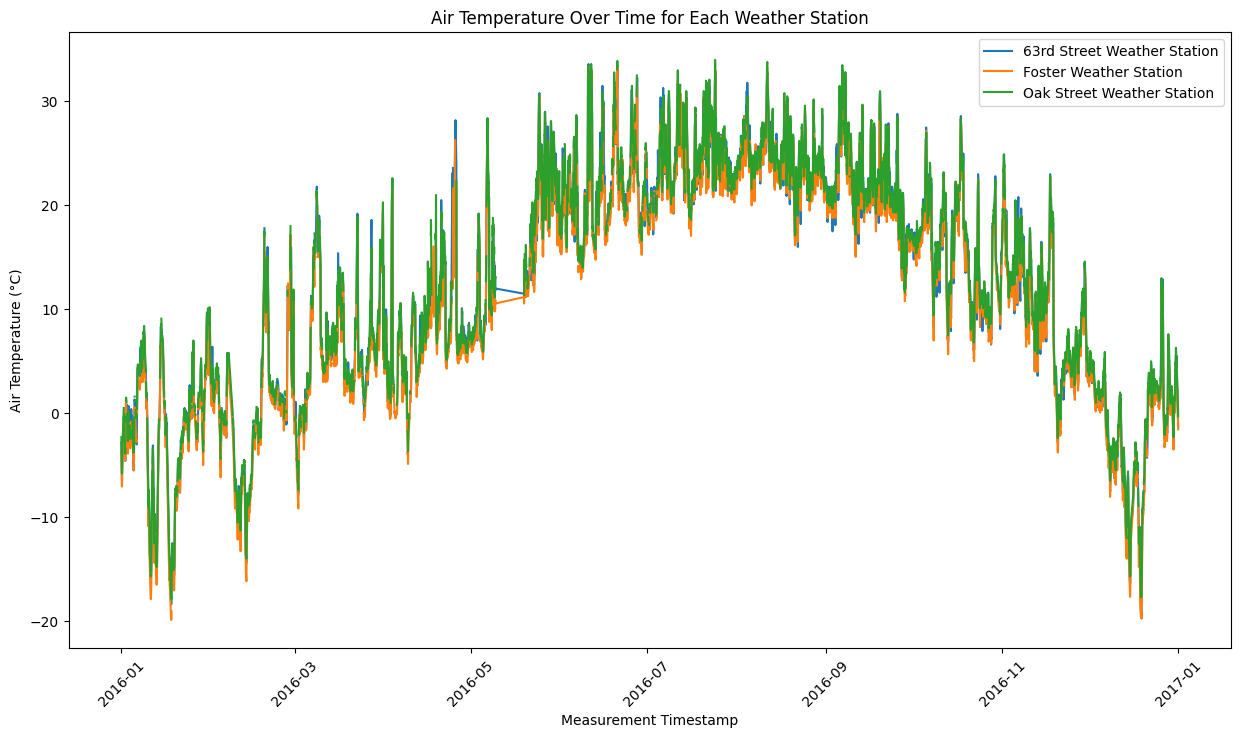

In [5]:
plt.figure(figsize=(15, 8))
for station in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[station], label=station)

plt.xlabel('Measurement Timestamp')
plt.ylabel('Air Temperature (°C)')
plt.title('Air Temperature Over Time for Each Weather Station')
plt.legend()
plt.xticks(rotation=45)
plt.show()

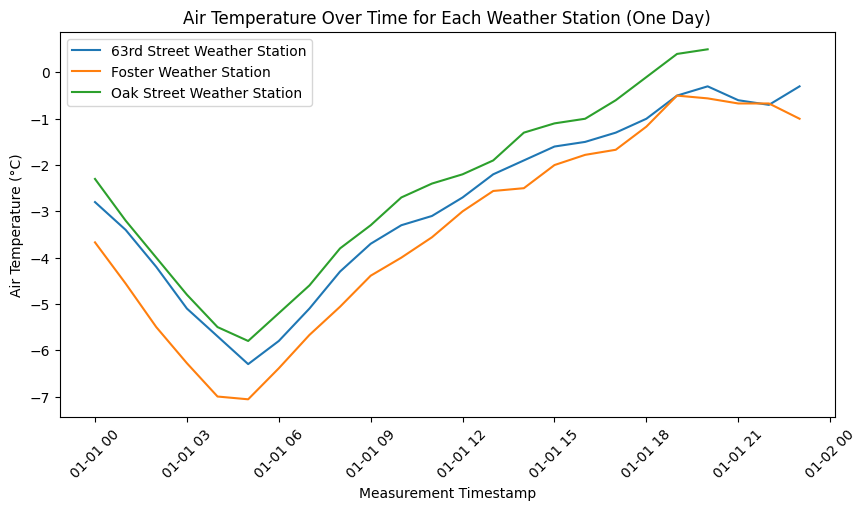

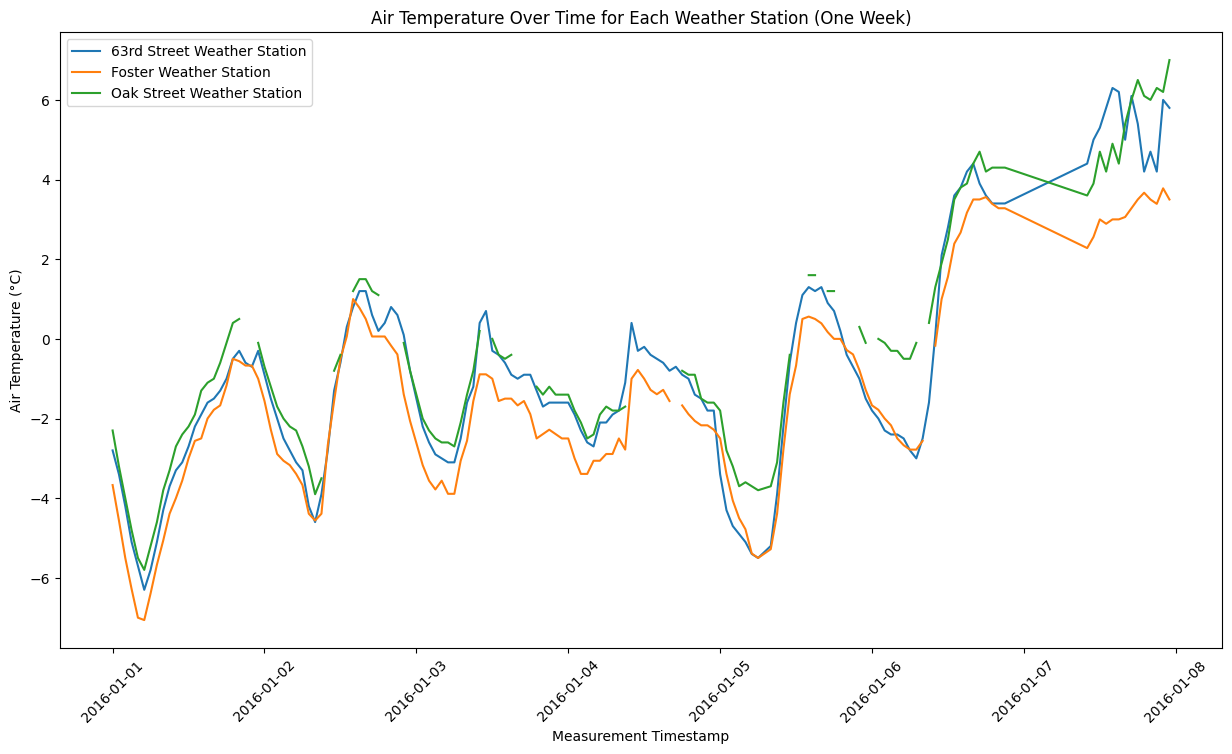

In [6]:
# Choose a random week and day within the dataset for specific plots
# Define a specific day and a specific week for closer inspection
one_day = df_pivot.loc['2016-01-01']
one_week = df_pivot.loc['2016-01-01':'2016-01-07']

# Plot for one day
plt.figure(figsize=(10, 5))
for station in one_day.columns:
    plt.plot(one_day.index, one_day[station], label=station)
plt.xlabel('Measurement Timestamp')
plt.ylabel('Air Temperature (°C)')
plt.title('Air Temperature Over Time for Each Weather Station (One Day)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Plot for one week
plt.figure(figsize=(15, 8))
for station in one_week.columns:
    plt.plot(one_week.index, one_week[station], label=station)
plt.xlabel('Measurement Timestamp')
plt.ylabel('Air Temperature (°C)')
plt.title('Air Temperature Over Time for Each Weather Station (One Week)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

So here we can observe some missing values, there are missing dates in may-june and maybe to some other places, let's give it a closer look

In [7]:
missing_values = df_pivot.isna().sum()

all_dates = pd.date_range(start=df_pivot.index.min(), end=df_pivot.index.max(), freq='H')
missing_dates = all_dates.difference(df_pivot.index)

missing_values, missing_dates.size

(Station Name
 63rd Street Weather Station    193
 Foster Weather Station         117
 Oak Street Weather Station     724
 dtype: int64,
 544)

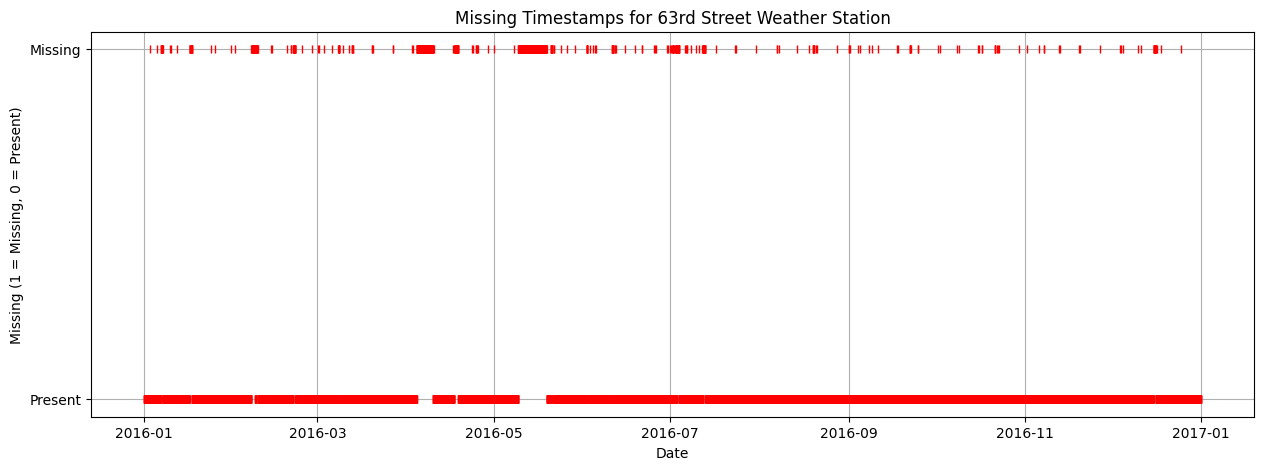

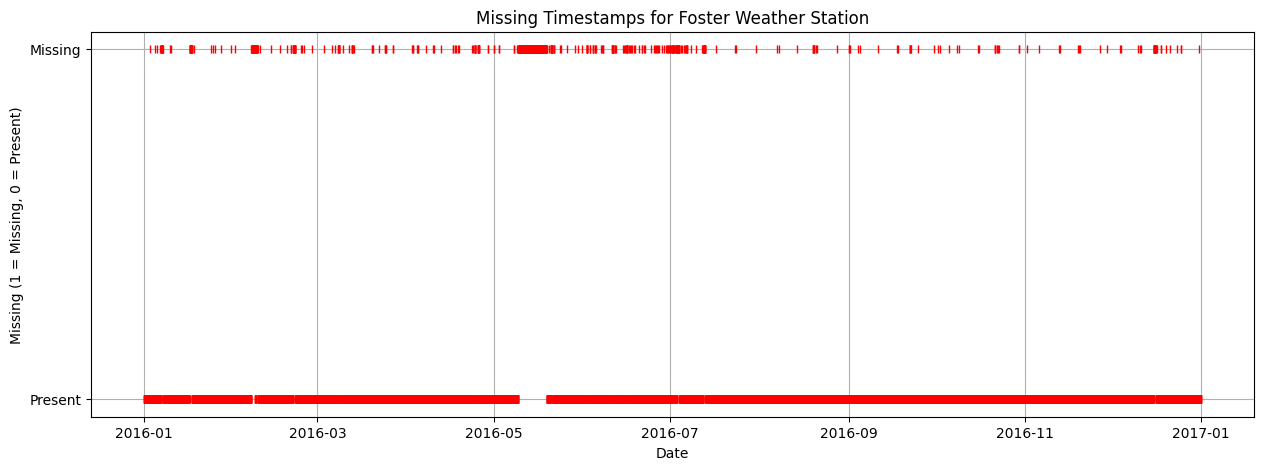

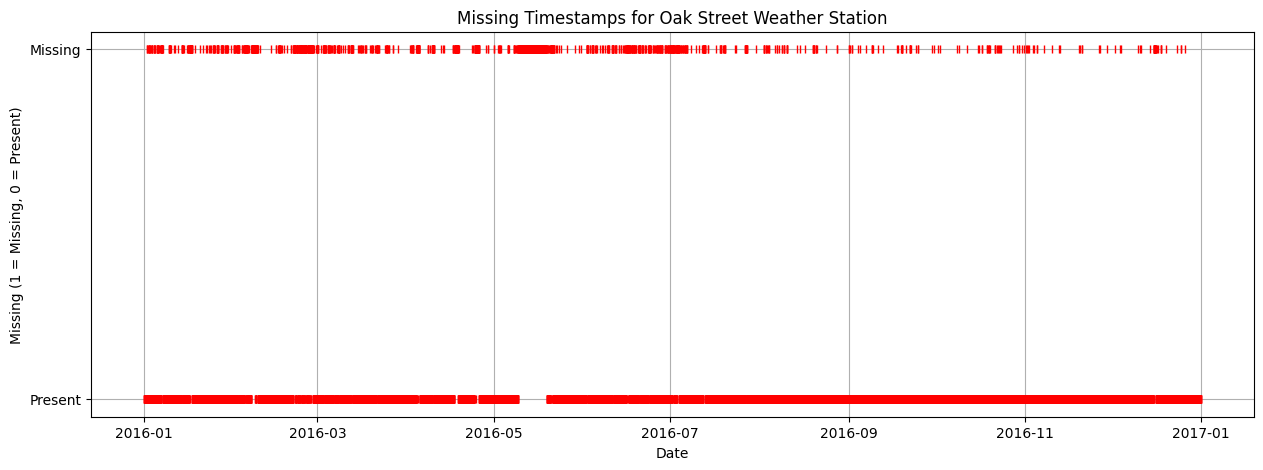

In [8]:
# Redefine missing dates by station
missing_dates_by_station = {}

# Identify missing dates for each station
for station in df_pivot.columns:
    station_data = df_pivot[station]
    station_data_reindexed = station_data.reindex(all_dates)
    missing_dates = all_dates[station_data_reindexed.isna()]
    missing_dates_by_station[station] = missing_dates

# Plot the missing dates for each station
for station, missing_dates in missing_dates_by_station.items():
    # Create a DataFrame to represent missing dates for visualization
    missing_dates_df = pd.DataFrame(index=all_dates)
    missing_dates_df['Missing'] = 0  # Default to 0 (not missing)
    missing_dates_df.loc[missing_dates, 'Missing'] = 1  # Set to 1 for missing dates
    
    # Plot the missing dates over time
    plt.figure(figsize=(15, 5))
    plt.plot(missing_dates_df.index, missing_dates_df['Missing'], marker='|', linestyle='None', color='red')
    plt.title(f'Missing Timestamps for {station}')
    plt.xlabel('Date')
    plt.ylabel('Missing (1 = Missing, 0 = Present)')
    plt.yticks([0, 1], ['Present', 'Missing'])
    plt.grid(True)
    plt.show()


Ok but I know these stations timeseries are highly correlated, I can do a test quickly here if you want

In [10]:
from itertools import combinations

# Calculate correlations between each pair of stations in df_pivot
correlations = {}
for station1, station2 in combinations(df_pivot.columns, 2):
    series1 = df_pivot[station1]
    series2 = df_pivot[station2]
    
    correlation = series1.corr(series2)
    correlations[(station1, station2)] = correlation
    print(f"Correlation between {station1} and {station2}: {correlation:.4f}")

correlations

Correlation between 63rd Street Weather Station and Foster Weather Station: 0.9957
Correlation between 63rd Street Weather Station and Oak Street Weather Station: 0.9955
Correlation between Foster Weather Station and Oak Street Weather Station: 0.9972


{('63rd Street Weather Station', 'Foster Weather Station'): 0.9957097352967557,
 ('63rd Street Weather Station',
  'Oak Street Weather Station'): 0.9954926654518723,
 ('Foster Weather Station', 'Oak Street Weather Station'): 0.9972033218453087}

In [11]:
for station in df_pivot.columns:
    # Identify missing indices in the current station's data
    missing_indices = df_pivot[station].isna()
    
    # For each missing index, calculate the average from available correlated stations
    for idx in df_pivot[station][missing_indices].index:
        # Collect data from other stations at the same timestamp if available
        available_data = [
            df_pivot[other_station].loc[idx] for other_station in df_pivot.columns if other_station != station and not pd.isna(df_pivot[other_station].loc[idx])
        ]
        
        # If data from other stations is available, fill with the average
        if available_data:
            df_pivot.loc[idx, station] = np.mean(available_data)


Go back up and run the graph -> reduced

Then interpolate the rest

In [12]:
#CAREFUL THIS ONE IS FOR ALL
'''
# Re-index to ensure all dates are present (including missing timestamps)
df_pivot = df_pivot.reindex(all_dates)

# Interpolate missing values linearly
df_pivot.interpolate(method='linear', inplace=True)

# Display head to verify
df_pivot.head()
'''

"\n# Re-index to ensure all dates are present (including missing timestamps)\ndf_pivot = df_pivot.reindex(all_dates)\n\n# Interpolate missing values linearly\ndf_pivot.interpolate(method='linear', inplace=True)\n\n# Display head to verify\ndf_pivot.head()\n"

In [13]:
# Define the maximum gap size for interpolation (e.g., 5 consecutive hours)
max_gap_size = 24

# Reindex to ensure all timestamps are present
df_pivot = df_pivot.reindex(all_dates)

# Loop through each station to identify and store large gaps
large_gap_indices = {}

for station in df_pivot.columns:
    station_data = df_pivot[station]
    
    # Create a mask for missing values
    missing_mask = station_data.isna()
    
    # Calculate the size of consecutive missing gaps
    gap_sizes = missing_mask.astype(int).groupby((~missing_mask).cumsum()).cumsum()
    
    # Store indices where the gap is larger than max_gap_size
    large_gap_indices[station] = station_data[gap_sizes > max_gap_size].index

    # Interpolate missing values for this station
    df_pivot[station] = station_data.interpolate() #df_pivot = df_pivot.interpolate() #fillna(method='ffill').fillna(method='bfill')

    # Reapply NaN to the large gaps in this station
    df_pivot.loc[large_gap_indices[station], station] = np.nan

Go back to the graph -> everything disappeared

Now we can process the data 

In [14]:
# Create lagged data for time series forecasting on all stations
station_names = df_pivot.columns
lagged_data = pd.DataFrame()

# Generate lagged features for each station
for station in station_names:
    for lag in range(1, 8):  # 7 lag days
        lagged_data[f'{station}_lag{lag}'] = df_pivot[station].shift(lag) # df_pivot[station].shift(24) can be interesting to add
    lagged_data[f'{station}_lag{lag}'] = df_pivot[station].shift(25)
# Set target variables for each station
for station in station_names:
    lagged_data[f'target_{station}'] = df_pivot[station]

# Drop rows with any NaN values (due to lagging)
lagged_data = lagged_data.dropna()

# Display the head of the resulting lagged dataset
lagged_data.head()


,63rd Street Weather Station_lag1,63rd Street Weather Station_lag2,63rd Street Weather Station_lag3,63rd Street Weather Station_lag4,63rd Street Weather Station_lag5,63rd Street Weather Station_lag6,63rd Street Weather Station_lag7,Foster Weather Station_lag1,Foster Weather Station_lag2,Foster Weather Station_lag3,...,Oak Street Weather Station_lag1,Oak Street Weather Station_lag2,Oak Street Weather Station_lag3,Oak Street Weather Station_lag4,Oak Street Weather Station_lag5,Oak Street Weather Station_lag6,Oak Street Weather Station_lag7,target_63rd Street Weather Station,target_Foster Weather Station,target_Oak Street Weather Station
2016-01-02 01:00:00,-0.9,-0.3,-0.7,-0.6,-0.3,-0.5,-2.8,-1.56,-1.00,-0.67,...,-0.7,-0.1,-0.685,-0.635,0.500,0.400,-2.3,-1.5,-2.28,-1.2
2016-01-02 02:00:00,-1.5,-0.9,-0.3,-0.7,-0.6,-0.3,-3.4,-2.28,-1.56,-1.00,...,-1.2,-0.7,-0.100,-0.685,-0.635,0.500,-3.2,-2.0,-2.89,-1.7
2016-01-02 03:00:00,-2.0,-1.5,-0.9,-0.3,-0.7,-0.6,-4.2,-2.89,-2.28,-1.56,...,-1.7,-1.2,-0.700,-0.100,-0.685,-0.635,-4.0,-2.5,-3.06,-2.0
2016-01-02 04:00:00,-2.5,-2.0,-1.5,-0.9,-0.3,-0.7,-5.1,-3.06,-2.89,-2.28,...,-2.0,-1.7,-1.200,-0.700,-0.100,-0.685,-4.8,-2.8,-3.17,-2.2
2016-01-02 05:00:00,-2.8,-2.5,-2.0,-1.5,-0.9,-0.3,-5.7,-3.17,-3.06,-2.89,...,-2.2,-2.0,-1.700,-1.200,-0.700,-0.100,-5.5,-3.1,-3.39,-2.3


Then let's play with Random Forest nom!

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Split data into training (before December) and validation (December only)
train_data = lagged_data[lagged_data.index < '2016-12-01']
val_data = lagged_data[(lagged_data.index >= '2016-12-01') & (lagged_data.index <= '2016-12-31')]

mae_scores = {}
forecast_results = {}

for station in station_names:
    # Prepare training and validation sets for the current station
    X_train = train_data.drop(columns=[f'target_{s}' for s in station_names])
    y_train = train_data[f'target_{station}']
    X_val = val_data.drop(columns=[f'target_{s}' for s in station_names])
    y_val = val_data[f'target_{station}']

    # Train a Random Forest Regressor for each station
    model = RandomForestRegressor(n_estimators=100)  # Hyperparameters can be tuned further
    model.fit(X_train, y_train)

    # Predict on the validation set
    y_pred = model.predict(X_val)
    mae_scores[station] = mean_squared_error(y_val, y_pred)

    # Store results for plotting
    forecast_results[station] = {
        'train': y_train,
        'validation': y_val,
        'forecast': y_pred
    }

# Plot results for each station
for station in station_names:
    results = forecast_results[station]
    
    plt.figure(figsize=(12, 6))
    plt.plot(results['train'].values, label="Train")
    plt.plot(range(len(results['train']), len(results['train']) + len(results['validation'])), 
             results['validation'].values, label="Validation")
    plt.plot(range(len(results['train']), len(results['train']) + len(results['forecast'])), 
             results['forecast'], label="Forecast")
    plt.legend()
    plt.title(f"Forecast for {station} - MAE: {mae_scores[station]:.2f}")
    plt.xlabel("Time")
    plt.ylabel("Temperature (°C)")
    plt.show()

# Print Mean Absolute Error scores for each station
print("MAE scores for each station:")
mae_scores


KeyboardInterrupt: 

In [ ]:
# print("Number of features:", X_train.shape[1])

# Feature Importance

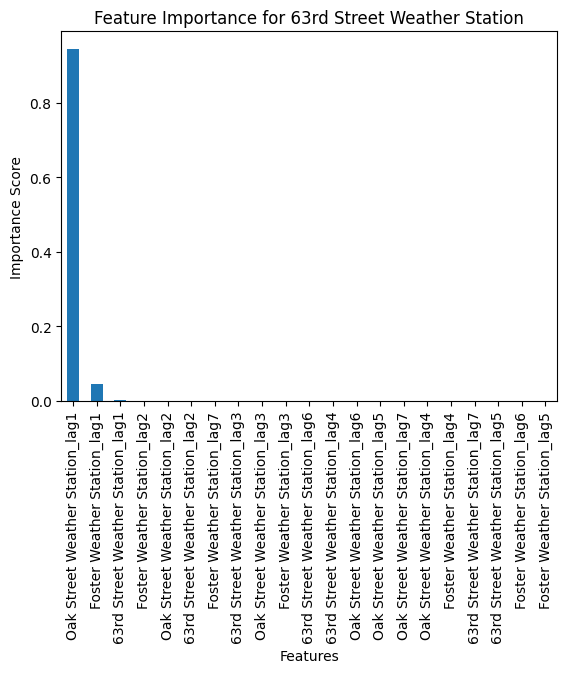

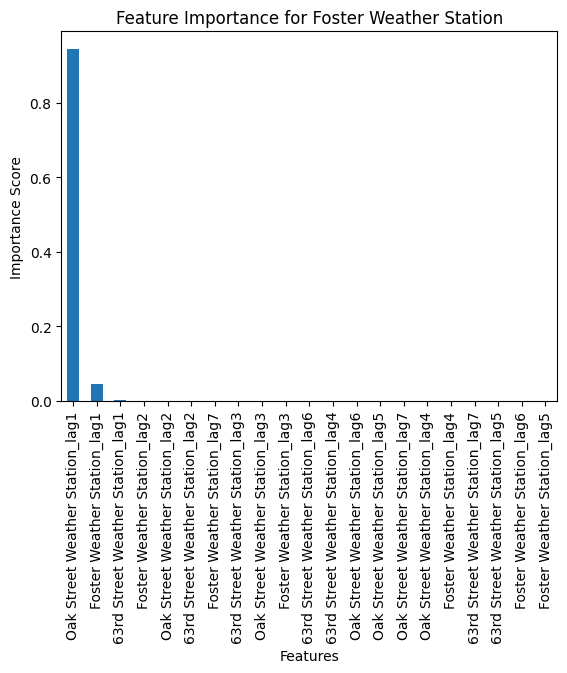

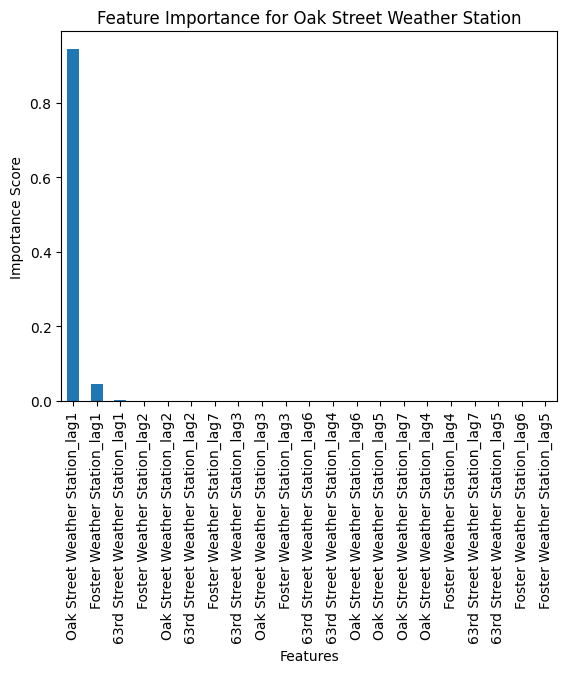

Top features for 63rd Street Weather Station:
Oak Street Weather Station_lag1: 0.9439
Foster Weather Station_lag1: 0.0459
63rd Street Weather Station_lag1: 0.0039
Foster Weather Station_lag2: 0.0006
Oak Street Weather Station_lag2: 0.0006


Top features for Foster Weather Station:
Oak Street Weather Station_lag1: 0.9439
Foster Weather Station_lag1: 0.0459
63rd Street Weather Station_lag1: 0.0039
Foster Weather Station_lag2: 0.0006
Oak Street Weather Station_lag2: 0.0006


Top features for Oak Street Weather Station:
Oak Street Weather Station_lag1: 0.9439
Foster Weather Station_lag1: 0.0459
63rd Street Weather Station_lag1: 0.0039
Foster Weather Station_lag2: 0.0006
Oak Street Weather Station_lag2: 0.0006




In [ ]:
importances = {}

for station in station_names:

    importances[station] = model.feature_importances_

    # Plot feature importance
    feature_importance_series = pd.Series(model.feature_importances_, index=X_train.columns)
    sorted_importance = feature_importance_series.sort_values(ascending=False)
    
    sorted_importance.plot(kind='bar')
    plt.title(f"Feature Importance for {station}")
    plt.xlabel("Features")
    plt.ylabel("Importance Score")
    plt.show()

# Print a summary of the top features for each station
for station, importance_values in importances.items():
    print(f"Top features for {station}:")
    sorted_features = sorted(zip(X_train.columns, importance_values), key=lambda x: x[1], reverse=True)
    for feature, score in sorted_features[:5]:  # Show top 5 features
        print(f"{feature}: {score:.4f}")
    print("\n")

# Grid Search with Out-of-Bag or val set

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import numpy as np

# Load the CSV file
file_path = 'C:/Users/natha/OneDrive/Bureau/Interview trainings/Coding/Aquatic/Weather_Forecast_Ideas/data/chicago_beach_weather.csv'
weather_data = pd.read_csv(file_path)

# Preprocess the data
weather_data['Measurement Timestamp'] = pd.to_datetime(weather_data['Measurement Timestamp'])
weather_data.set_index('Measurement Timestamp', inplace=True)

# Pivot the data by station name and fill any missing values
df_pivot = weather_data.pivot(columns='Station Name', values='Air Temperature')
df_pivot = df_pivot.fillna(method='ffill').fillna(method='bfill')

# Generate lagged features
station_names = df_pivot.columns
lagged_data = pd.DataFrame()

# Create lagged features for each station
for station in station_names:
    for lag in range(1, 8):  # 7 hours lag
        lagged_data[f'{station}_lag{lag}'] = df_pivot[station].shift(lag)

# Add each station's current value as a target
for station in station_names:
    lagged_data[f'target_{station}'] = df_pivot[station]

# Drop rows with NaN values after creating lags
lagged_data = lagged_data.dropna()

# Split data into training (before December) and validation (December only)
train_data = lagged_data[lagged_data.index < '2016-12-01']
val_data = lagged_data[(lagged_data.index >= '2016-12-01') & (lagged_data.index <= '2016-12-31')]

# Define the parameter grid for hyperparameter optimization
param_dist = {
    'n_estimators': np.arange(50, 201, 50),  # Try 50, 100, 150, 200
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 4, 8],
    'max_features': ['sqrt', 'log2'],
    'max_samples': [0.8, 0.9, 1.0]
}

# Dictionary to store results for each station
best_params = {}
mae_scores = {}
forecast_results = {}

# Use a time series split for cross-validation to preserve the temporal order
tscv = TimeSeriesSplit(n_splits=5)

# Train and predict for each station
for station in station_names:
    X_train = train_data.drop(columns=[f'target_{s}' for s in station_names])
    y_train = train_data[f'target_{station}']
    X_val = val_data.drop(columns=[f'target_{s}' for s in station_names])
    y_val = val_data[f'target_{station}']
    
    # Perform random search with cross-validation
    random_search = RandomizedSearchCV(
        RandomForestRegressor(random_state=123, oob_score=True),
        param_distributions=param_dist,
        n_iter=30,  # Number of parameter settings to sample
        cv=tscv,
        scoring='neg_mean_absolute_error',
        random_state=123
    )
    random_search.fit(X_train, y_train)
    
    # Train the final model using the best parameters
    best_station_params = random_search.best_params_
    best_model = RandomForestRegressor(**best_station_params, random_state=123, oob_score=True)
    best_model.fit(X_train, y_train)
    
    # Predict and compute MAE for the validation set
    y_pred = best_model.predict(X_val)
    mae_scores[station] = mean_absolute_error(y_val, y_pred)
    best_params[station] = best_station_params
    
    # Store the forecast, validation, and training sets for plotting
    forecast_results[station] = {
        'train': y_train,
        'validation': y_val,
        'forecast': y_pred
    }

# Plot the forecast, validation, and training sets for each station
for station in station_names:
    results = forecast_results[station]
    
    plt.figure(figsize=(12, 6))
    plt.plot(results['train'].values, label="Train")
    plt.plot(range(len(results['train']), len(results['train']) + len(results['validation'])), 
             results['validation'].values, label="Validation")
    plt.plot(range(len(results['train']), len(results['train']) + len(results['forecast'])), 
             results['forecast'], label="Forecast")
    plt.legend()
    plt.title(f"Forecast for {station} - MAE: {mae_scores[station]:.2f}")
    plt.xlabel("Time")
    plt.ylabel("Temperature")
    plt.show()

# Display MAE scores and best parameters for each station
print("MAE Scores per Station:", mae_scores)
print("Best Parameters per Station:", best_params)


# Uncerntainty Quantification

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the CSV file
file_path = 'C:/Users/natha/OneDrive/Bureau/Interview trainings/Coding/Aquatic/Weather_Forecast_Ideas/data/chicago_beach_weather.csv'
weather_data = pd.read_csv(file_path)

# Preprocess the data
weather_data['Measurement Timestamp'] = pd.to_datetime(weather_data['Measurement Timestamp'])
weather_data.set_index('Measurement Timestamp', inplace=True)

# Pivot the data by station name and fill any missing values
df_pivot = weather_data.pivot(columns='Station Name', values='Air Temperature')
df_pivot = df_pivot.fillna(method='ffill').fillna(method='bfill')

# Generate lagged features
station_names = df_pivot.columns
lagged_data = pd.DataFrame()

# Create lagged features for each station
for station in station_names:
    for lag in range(1, 8):  # 7 hours lag
        lagged_data[f'{station}_lag{lag}'] = df_pivot[station].shift(lag)

# Add each station's current value as a target
for station in station_names:
    lagged_data[f'target_{station}'] = df_pivot[station]

# Drop rows with NaN values after creating lags
lagged_data = lagged_data.dropna()

# Split data into training (before December) and validation (December only)
train_data = lagged_data[lagged_data.index < '2016-12-01']
val_data = lagged_data[(lagged_data.index >= '2016-12-01') & (lagged_data.index <= '2016-12-31')]

# Dictionary to store results for each station
mae_scores = {}
forecast_results = {}

# Train and predict for each station
for station in station_names:
    X_train = train_data.drop(columns=[f'target_{s}' for s in station_names])
    y_train = train_data[f'target_{station}']
    X_val = val_data.drop(columns=[f'target_{s}' for s in station_names])
    y_val = val_data[f'target_{station}']
    
    # Train a single RandomForestRegressor model with predefined parameters
    model = RandomForestRegressor(n_estimators=100, random_state=123) #max_depth=10, min_samples_split=5, min_samples_leaf=2, max_features='sqrt', , oob_score=True
                                  
    model.fit(X_train, y_train)
    
    # Get predictions from each tree in the forest for the validation set
    all_tree_predictions = np.array([tree.predict(X_val.values) for tree in model.estimators_])

    # Calculate mean and standard deviation of predictions across all trees
    mean_predictions = np.mean(all_tree_predictions, axis=0)
    std_predictions = np.std(all_tree_predictions, axis=0)

    # Compute MAE for the mean predictions
    mae_scores[station] = mean_absolute_error(y_val, mean_predictions)
    
    # Store the forecast, validation, and training sets for plotting
    forecast_results[station] = {
        'validation': y_val,
        'forecast': mean_predictions,
        'std': std_predictions
    }

# Plot only the December forecast with uncertainty band for each station
for station in station_names:
    results = forecast_results[station]
    
    plt.figure(figsize=(12, 6))
    plt.plot(results['validation'].index, results['validation'].values, label="Actual (Validation)", color="green")
    plt.plot(results['validation'].index, results['forecast'], label="Mean Prediction", color="orange")
    plt.fill_between(results['validation'].index, 
                     results['forecast'] - results['std'], 
                     results['forecast'] + results['std'], 
                     color="orange", alpha=0.2, label="Prediction ± 1 std")
    plt.legend()
    plt.title(f"December Forecast for {station} - MAE: {mae_scores[station]:.2f}")
    plt.xlabel("Time")
    plt.ylabel("Temperature")
    plt.xticks(rotation=45)
    plt.show()

# Display MAE scores for each station
print("MAE Scores per Station:", mae_scores)


# To improve:
- More robust cross validation
- Add more features
- try xgboost / ensemble of xgboost, TFT
- Question about testing methodology 